# Problem 2 Sample Code

This sample code is meant as a guide on how to use PyTorch and how to use the relevant model layers. This not a guide on how to design a network and the network in this example is intentionally designed to have poor performace.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [8]:
print(torch.__version__)
print(torchvision.__version__)

2.5.1+cu124
0.20.1+cu124


## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [6]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [7]:
print(len(train_dataset), type(train_dataset[0][0]), type(train_dataset[0][1]))

60000 <class 'torch.Tensor'> <class 'int'>


We can convert images to numpy arrays and plot them with matplotlib:

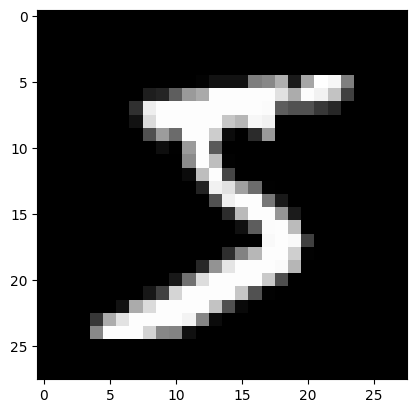

In [4]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

In [12]:
print(len(train_dataset[0]))
print(len(train_dataset[0][0]))
print(len(train_dataset[0][0][0]))
print(train_dataset[0][0].shape)
print(len(test_dataset))
print(train_dataset[0][0])

2
1
28
torch.Size([1, 28, 28])
10000
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.

## Network Definition
Let's instantiate a model and take a look at the layers.

In [13]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),
    nn.Linear(784, 20),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(20, 10)
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=20, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=20, out_features=10, bias=True)
)


## Training
We also choose an optimizer and a loss function.

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

We could write our training procedure manually and directly index the `Dataset` objects, but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

We now write our backpropagation loop, training for 10 epochs.

In [16]:
# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(10):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 1.0164
Train Epoch: 2  Loss: 0.6868
Train Epoch: 3  Loss: 0.5819
Train Epoch: 4  Loss: 0.5086
Train Epoch: 5  Loss: 0.3763
Train Epoch: 6  Loss: 0.5156
Train Epoch: 7  Loss: 1.0516
Train Epoch: 8  Loss: 0.4638
Train Epoch: 9  Loss: 0.3716
Train Epoch: 10  Loss: 0.5505


## Testing
We can perform forward passes through the network without saving gradients.

In [17]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0082, Accuracy: 9262/10000 (92.6200)


Problem 2C

In [8]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(100, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.1581
Train Epoch: 2  Loss: 0.1861
Train Epoch: 3  Loss: 0.0834
Train Epoch: 4  Loss: 0.1581
Train Epoch: 5  Loss: 0.2797
Train Epoch: 6  Loss: 0.3629
Train Epoch: 7  Loss: 0.1642
Train Epoch: 8  Loss: 0.0865
Train Epoch: 9  Loss: 0.1303
Train Epoch: 10  Loss: 0.0450
Train Epoch: 11  Loss: 0.3006
Train Epoch: 12  Loss: 0.2281
Train Epoch: 13  Loss: 0.0997
Train Epoch: 14  Loss: 0.0841
Train Epoch: 15  Loss: 0.2620
Train Epoch: 16  Loss: 0.1080
Train Epoch: 17  Loss: 0.3298
Train Epoch: 18  Loss: 0.0376
Train Epoch: 19  Loss: 0.0756
Train Epoch: 20  Loss: 0.0209


In [9]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0029, Accuracy: 9751/10000 (97.5100)


Problem 2D:

In [10]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.3620
Train Epoch: 2  Loss: 0.4760
Train Epoch: 3  Loss: 0.3902
Train Epoch: 4  Loss: 0.0581
Train Epoch: 5  Loss: 0.0554
Train Epoch: 6  Loss: 0.3513
Train Epoch: 7  Loss: 0.1677
Train Epoch: 8  Loss: 0.0811
Train Epoch: 9  Loss: 0.0221
Train Epoch: 10  Loss: 0.0479
Train Epoch: 11  Loss: 0.0236
Train Epoch: 12  Loss: 0.0111
Train Epoch: 13  Loss: 0.2544
Train Epoch: 14  Loss: 0.0148
Train Epoch: 15  Loss: 0.1086
Train Epoch: 17  Loss: 0.1341
Train Epoch: 18  Loss: 0.0010
Train Epoch: 19  Loss: 0.0376
Train Epoch: 20  Loss: 0.0950


In [11]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0019, Accuracy: 9821/10000 (98.2100)


Problem 2E:

In [12]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 500),
    nn.ReLU(),
    nn.Linear(500, 250),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(250, 10)

)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()

        # Weight update
        optimizer.step()

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.3359
Train Epoch: 2  Loss: 0.1132
Train Epoch: 3  Loss: 0.0211
Train Epoch: 4  Loss: 0.1303
Train Epoch: 5  Loss: 0.1597
Train Epoch: 6  Loss: 0.0579
Train Epoch: 7  Loss: 0.0651
Train Epoch: 8  Loss: 0.0698
Train Epoch: 9  Loss: 0.1168
Train Epoch: 10  Loss: 0.0410
Train Epoch: 11  Loss: 0.1220
Train Epoch: 12  Loss: 0.1076
Train Epoch: 13  Loss: 0.0022
Train Epoch: 14  Loss: 0.0941
Train Epoch: 15  Loss: 0.0086
Train Epoch: 16  Loss: 0.0019
Train Epoch: 17  Loss: 0.0160
Train Epoch: 18  Loss: 0.0539
Train Epoch: 19  Loss: 0.0181
Train Epoch: 20  Loss: 0.0273


In [13]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0024, Accuracy: 9835/10000 (98.3500)
